In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Data_Prep_After_FE.csv')

df.set_index('startdatetime', inplace=True)

In [3]:
df.head()

,ama,hour,minute,duration,dayofweek,dayofyear,weeknum,month,quarter,year,...,distributor_Sticky Fingers Production Inc.,distributor_TBS,distributor_Warner Brothers,distributor_eOne,cat_genre_Cat_Comedy,cat_genre_Cat_Comedy_Romance,cat_genre_Cat_Doc_Crime_Mystery,cat_genre_Cat_Other_Genre,cat_genre_Cat_Reality_Competition,cat_genre_Cat_Talk_Show
startdatetime,,,,,,,,,,,,,,,,,,,,,
2020-12-28 02:00:00,16.161650,2,0,30,0,363,53,12,4,2020,...,0,0,1,0,1,0,0,0,0,0
2020-12-28 02:30:00,12.645497,2,30,30,0,363,53,12,4,2020,...,0,0,1,0,1,0,0,0,0,0
2020-12-28 03:00:00,10.923170,3,0,30,0,363,53,12,4,2020,...,0,0,1,0,1,0,0,0,0,0
2020-12-28 03:30:00,10.517880,3,30,30,0,363,53,12,4,2020,...,0,0,1,0,1,0,0,0,0,0
2020-12-28 04:00:00,3.072320,4,0,30,0,363,53,12,4,2020,...,0,0,1,0,1,0,0,0,0,0


In [4]:
X = df.drop(['ama'], axis=1)
y = df['ama']

test_split_date = '2023-07-01'

X_train = X.loc[X.index<test_split_date]

X_test = X.loc[X.index>=test_split_date]

y_train = y.loc[y.index<test_split_date]

y_test = y.loc[y.index>=test_split_date]

In [6]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Creating a LightGBM dataset from the training data
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)

# Optional: creating a LightGBM dataset from the testing data for validation
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [7]:
!pip install optuna

  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached Mako-1.3.3-py3-none-any.whl.metadata (2.9 kB)
Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)
Using cached Mako-1.3.3-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
import optuna
import lightgbm as lgb

In [14]:
def objective(trial):
    # Define the hyperparameter configuration
    param = {
        'objective': 'regression',
        'metric': 'l1',  # L1 loss is MAE
        'verbosity': -1,
        'boosting_type': 'dart',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
    }

    # Create a LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test)
    evals_result ={}
    # Train the model
    # model = lgb.train(param, train_data, valid_sets=[valid_data], verbose_eval=False, early_stopping_rounds=100)
    model = lgb.train(param, train_data,
                  num_boost_round=300,
                  valid_sets=[valid_data],
                  valid_names=['valid'],
                  # callbacks=[lgb.early_stopping(stopping_rounds=3),]
                  callbacks=[lgb.record_evaluation(evals_result)]
                     )

    # Predictions
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Details of the best trial
best_trial = study.best_trial
print(f'Best trial final validation MAE: {best_trial.value}')
print(f'Best parameters:')
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

[I 2024-04-14 19:37:26,015] A new study created in memory with name: no-name-ba0bed9b-39dd-4fa3-a39a-e6cde07ad8ad
[I 2024-04-14 19:37:41,507] Trial 0 finished with value: 13.052537522655035 and parameters: {'num_leaves': 176, 'learning_rate': 0.1887560102293325, 'feature_fraction': 0.876929023733727, 'subsample': 0.6317238595743637, 'max_depth': 19}. Best is trial 0 with value: 13.052537522655035.
[I 2024-04-14 19:37:52,698] Trial 1 finished with value: 11.971179517071691 and parameters: {'num_leaves': 77, 'learning_rate': 0.04657706027751982, 'feature_fraction': 0.6487519537474555, 'subsample': 0.995935195312878, 'max_depth': 20}. Best is trial 1 with value: 11.971179517071691.
[I 2024-04-14 19:38:10,855] Trial 2 finished with value: 13.052784543101799 and parameters: {'num_leaves': 165, 'learning_rate': 0.2309351475915484, 'feature_fraction': 0.8035762615276558, 'subsample': 0.8487163022000173, 'max_depth': 14}. Best is trial 1 with value: 11.971179517071691.
[I 2024-04-14 19:38:20,0

Number of finished trials: 200
Best trial: {'num_leaves': 87, 'learning_rate': 0.016760052712894036, 'feature_fraction': 0.4734093789977771, 'subsample': 0.8314177331436383, 'max_depth': 13}
Best trial final validation MAE: 11.458597228434039
Best parameters:
num_leaves: 87
learning_rate: 0.016760052712894036
feature_fraction: 0.4734093789977771
subsample: 0.8314177331436383
max_depth: 13


In [16]:
# Best parameters from Optuna study
params = {
    'boosting_type': 'dart',
    'num_leaves': 87,
    'learning_rate': 0.016760052712894036,
    'feature_fraction': 0.4734093789977771,
    'subsample': 0.8314177331436383,
    'max_depth': 13,
    'objective': 'regression',
    'metric': 'l1'  # MAE
}

# Train the model
model = lgb.train(params, lgb_train, num_boost_round=300, valid_sets=[lgb_eval])

# Predictions
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print('Mean Absolute Error on Test Set:', mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4511
[LightGBM] [Info] Number of data points in the train set: 42676, number of used features: 91
[LightGBM] [Info] Start training from score 27.951123
Mean Absolute Error on Test Set: 11.458597228434039


In [ ]:
# RMSE, MSE

In [27]:
# Predictions on training
preds_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, preds_train)
print('Mean Absolute Error on Train Set:', mae_train)

Mean Absolute Error on Train Set: 12.53351263332346


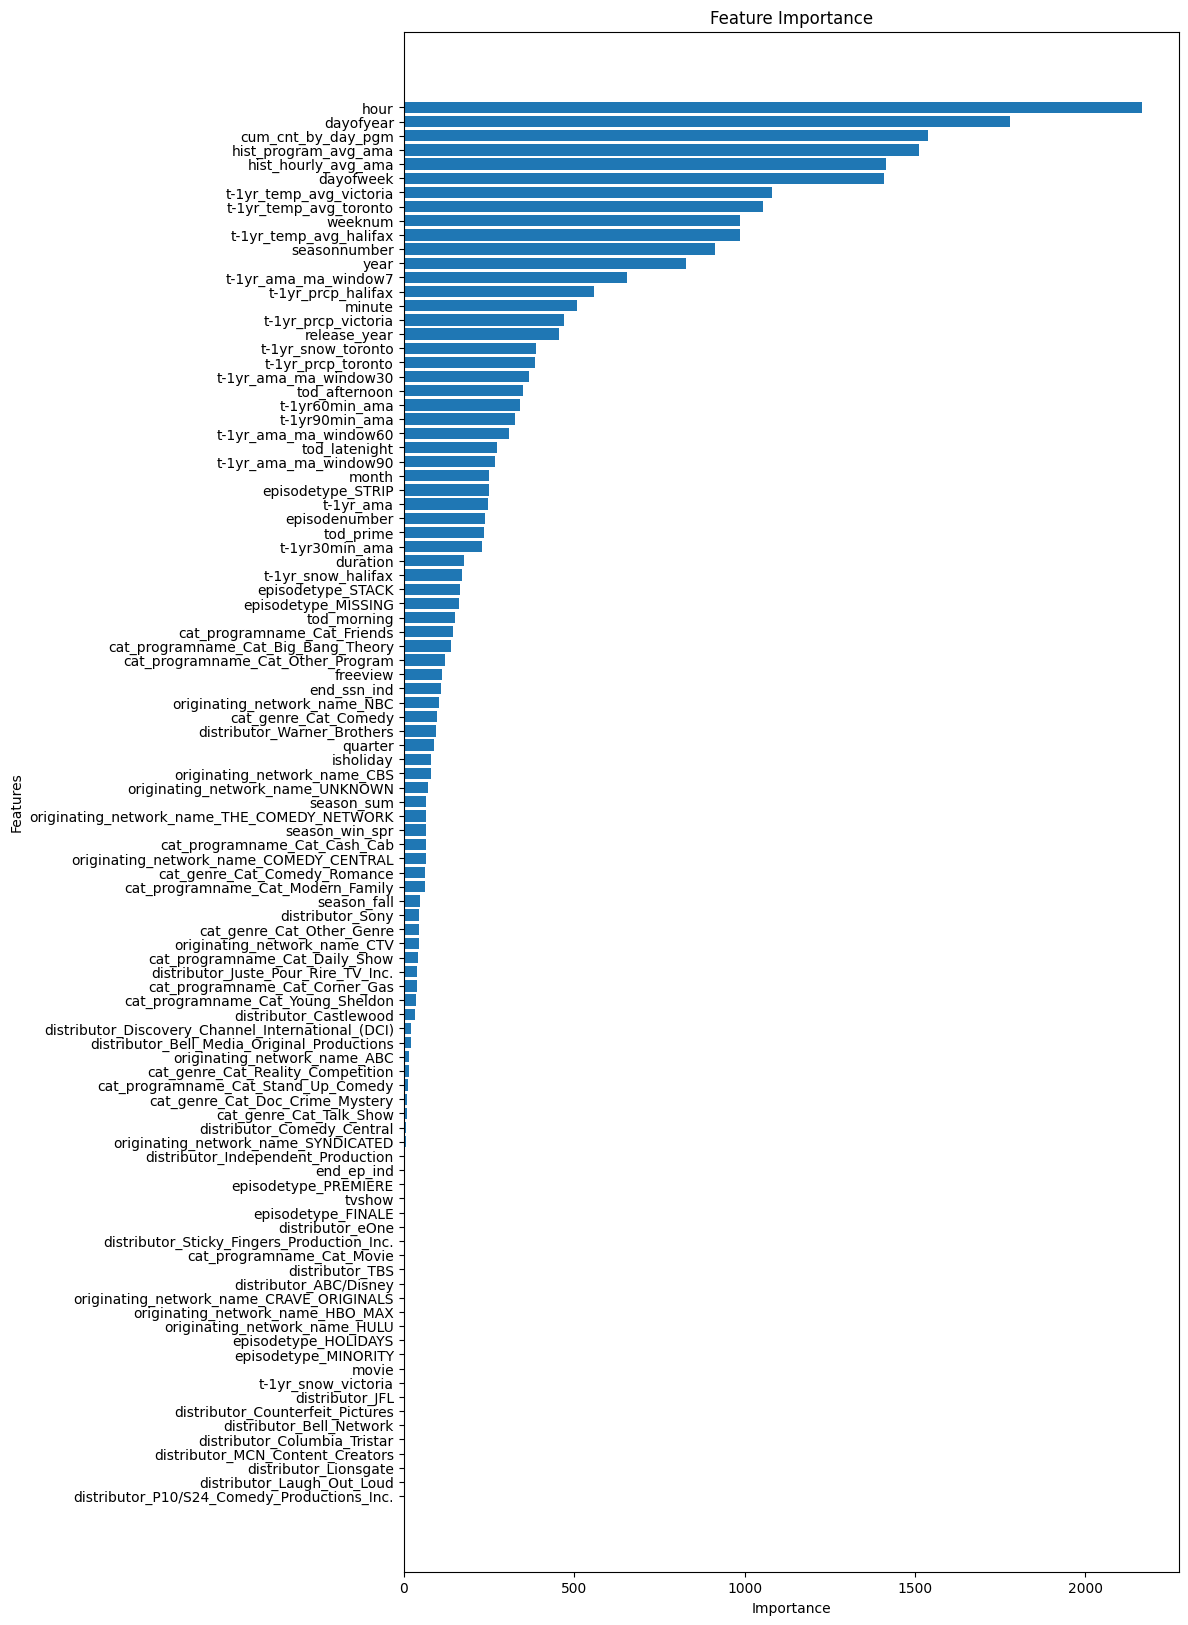

In [25]:
import matplotlib.pyplot as plt
# Get feature importances
importances = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

# Create a feature importance dataframe
importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature Name'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert axis to have the most important at the top
plt.show()